In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
data = pd.read_excel(url)

# The last two columns are the target variables (Heating Load and Cooling Load)
X = data.iloc[:, :-2].values  # Covariates
y_heating = data.iloc[:, -2].values  # Heating Load

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_heating, test_size=0.2, random_state=42)


In [8]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# Define the Bayesian Linear Regression Model
def model(X, y=None):
    n_features = X.shape[1]
    
    # Priors for the weights and intercept
    weights = numpyro.sample("weights", dist.Normal(jnp.zeros(n_features), jnp.ones(n_features)))
    intercept = numpyro.sample("intercept", dist.Normal(0., 1.))
    
    # Noise term
    sigma = numpyro.sample("sigma", dist.Exponential(1.))
    
    # Linear prediction
    mean = jnp.dot(X, weights) + intercept
    
    # Likelihood
    numpyro.sample("obs", dist.Normal(mean, sigma), obs=y)

# Initialize the MCMC sampler with NUTS (No U-Turn Sampler)
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2000, num_chains=1)


In [9]:
# Fit the model using the training data
X_train_jnp = jnp.array(X_train)
y_train_jnp = jnp.array(y_train)

# Run MCMC to sample from the posterior
mcmc.run(jax.random.PRNGKey(0), X_train_jnp, y_train_jnp)

# Print summary of posterior samples
mcmc.print_summary()


sample: 100%|██████████| 2500/2500 [00:11<00:00, 223.85it/s, 1023 steps of size 5.90e-04. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  intercept     -1.07      0.96     -1.01     -2.63      0.49     38.17      1.00
      sigma      3.38      0.10      3.37      3.23      3.57     53.26      1.00
 weights[0]     -2.62      0.96     -2.67     -4.26     -1.17     49.41      1.01
 weights[1]      0.08      0.49      0.11     -0.81      0.90     10.46      1.06
 weights[2]     -0.04      0.49     -0.07     -0.86      0.85     10.44      1.06
 weights[3]     -0.23      0.98     -0.28     -1.87      1.57     10.48      1.06
 weights[4]      3.48      0.17      3.48      3.18      3.74     48.03      1.00
 weights[5]     -0.06      0.12     -0.07     -0.26      0.14     74.11      1.00
 weights[6]      9.69      0.80      9.61      8.57     11.14     40.01      1.04
 weights[7]      0.38      0.08      0.38      0.25      0.51     42.35      1.11

Number of divergences: 0


In [11]:
from numpyro.infer import Predictive

# Create a predictive distribution using the posterior samples
posterior_samples = mcmc.get_samples()

predictive = Predictive(model, posterior_samples)
X_test_jnp = jnp.array(X_test)

# Generate predictions for the test set
predictions = predictive(jax.random.PRNGKey(1), X_test_jnp)
y_pred_samples = predictions['obs']

# Calculate the mean predictions
y_pred_mean = jnp.mean(y_pred_samples, axis=0)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate the mean predictions
y_pred_mean = jnp.mean(y_pred_samples, axis=0)

# Calculate the 95% predictive interval
y_pred_lower = jnp.percentile(y_pred_samples, 2.5, axis=0)
y_pred_upper = jnp.percentile(y_pred_samples, 97.5, axis=0)


# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred_mean)
rmse = mean_squared_error(y_test, y_pred_mean, squared=False)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 2.508495222463236
Root Mean Squared Error (RMSE): 3.4456015500302795


/home/rnaveiro/anaconda3/envs/posterior_attraction/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


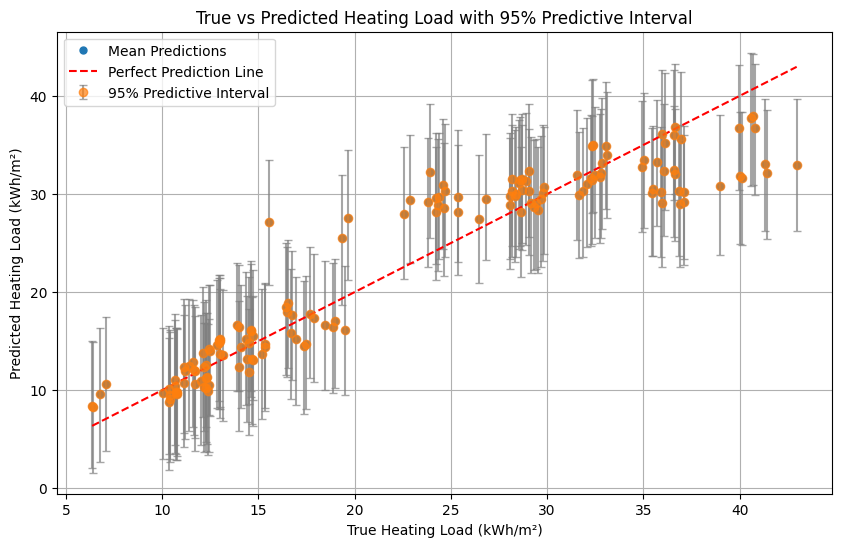

In [20]:
# Plot the real vs predicted values with 95% predictive intervals
plt.figure(figsize=(10, 6))
plt.plot(y_test, y_pred_mean, 'o', label="Mean Predictions", markersize=5)
plt.errorbar(y_test, y_pred_mean, yerr=[y_pred_mean - y_pred_lower, y_pred_upper - y_pred_mean], fmt='o', ecolor='gray', alpha=0.7, label="95% Predictive Interval", capsize=3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Perfect Prediction Line")  # Perfect prediction line
plt.xlabel("True Heating Load (kWh/m²)")
plt.ylabel("Predicted Heating Load (kWh/m²)")
plt.title("True vs Predicted Heating Load with 95% Predictive Interval")
plt.legend()
plt.grid(True)
plt.show()

